Nonlinear MLP Stencil

Goal: Use MLP to train nonlinear stencil

In [ ]:
# Essential packages
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.func import jacrev, vmap, functional_call

Define MLP to output stencil perturbation and build nonlinear residual

In [27]:
class StencilMLP(nn.Module):
    """Map local stencil to perturbation coeff using MLP
    Input: local solution
    Output: perturbation weights
    """
    def __init__(self, stencil_width=3, hidden=16):
        super().__init__() # initialize parent
        self.net = nn.Sequential(
            nn.Linear(stencil_width, hidden), # layer1: input
            nn.Tanh(), # layer2: activation func
            nn.Linear(hidden, hidden), # layer3: hidden to hidden
            nn.Tanh(), # layer4: activation func
            nn.Linear(hidden, stencil_width), # layer 5: map hidden to output
        )
        with torch.no_grad():
            self.net[-1].weight.zero_() # set all weights in the final layer to zero
            self.net[-1].bias.zero_() # set all biases to zero

    def forward(self, u_local):
        return self.net(u_local)
    
def extract_stencil_windows(u, stencil_radius=1):
    # Extract all local stencil windows from u with periodic BCs
    N = u.shape[0]
    width = 2 * stencil_radius + 1
    u_padded = torch.cat([u[-stencil_radius:], u, u[:stencil_radius]])
    windows = u_padded.unfold(0, width, 1)
    return windows

def apply_nonlinear_stencil(u, mlp_params, mlp_buffers, mlp_forward, base_coeffs):
    # Apply nonlinear stencil to the full solution vector u
    windows = extract_stencil_windows(u)
    delta_a = mlp_forward(mlp_params, mlp_buffers, windows)
    a_eff = base_coeffs.unsqueeze(0) + delta_a
    Lu = (a_eff * windows).sum(dim=1)
    return Lu

Implicit Euler Residual and Jacobian

In [21]:
# Compute residual u_new - u_old - dt * Lu for the full system
def implicit_euler_residual(u_new, u_old, dt, mlp_params, mlp_buffers,
                            mlp_forward, base_coeffs):
    Lu = apply_nonlinear_stencil(u_new, mlp_params, mlp_buffers, mlp_forward, base_coeffs)
    return u_new - u_old - dt * Lu

# Compute the residual for a single spatial point i using its local stencil (3 points)
def local_residual_i(u_local_3, i, u_full ,u_old_i, dt, mlp_buffers, mlp_forward, base_coeefs):
    delta_a = mlp_forward(mlp_params, mlp_buffers, u_local_3.unsqueeze(0)).squeeze(0) 
    a_eff = base_coeffs + delta_a  
    Lu_i = (a_eff * u_local_3).sum()
    return u_local_3[1] - u_old_i - dt * Lu_i 

# Build Jacobian Matrix
def assemble_jacobian_banded(u_new, u_old, dt, mlp_params, mlp_buffers, mlp_forward, base_coeffs):
    N = u_new.shape[0]
    windows = extract_stencil_window(u_new)

    def local_res_fn(u_local_3, u_old_i):
        delta_a = mlp_forward(mlp_params, mlp_buffers, u_local_3.unsqueeze(0)).squeeze(0)
        a_eff = base_coeffs + delta_a
        Lu_i = (a_eff * u_local_3).sum()
        return u_local_3[1] - u_old_i - dt * Lu_i
    
    local_jac_fn = jacrev(local_res_fn, argnums=0)
    all_loacl_jacs = vmap(local_jac_fn)(windows, u_old)

    J = torch.zeros(N, N, dtype=u_new.dtype, device=u_new.device)
    idx = torch.arange(N, device=u_new.device)

    for k in range(3):
        col = (idx + (k - 1)) % N
        J[idx, col] = all_loacl_jacs[:, k]

    return J

Newton Solver with Armijo backtracking

In [16]:
def newton_solve(u_init, u_old, dt, mlp_params, mlp_buffers, mlp_forward,
                 base_coeffs, tol=1e-10, max_iter=20, verbose=False):
    
    u = u_init.detach().clone()

    for k in range(max_iter):
        with torch.no_grad():
            F_val = implicit_euler_residual(u, u_old, dt, mlp_params, mlp_buffers, mlp_forward, base_coeffs)

            res_norm = F_val.norm().item()
            if verbose:
                print(f"Newton iter {k}: ||F|| = {res_norm:.3e}")
                if res_norm < tol:
                    break
        with torch.enable_grad():
            J = assemble_jacobian_banded(u, u_old, dt, mlp_params, mlp_buffers, mlp_forward, base_coeffs)
        with torch.no_grad():
            delta_u = torch.linalg.solve(J.detach(), -F_val)

            alpha = 1.0
            c1 = 1e-4
            tau = 0.5
            phi_current = 0.5 * F_val.dot(F_val)
            directional_deriv = -F_val.dot(F_val)

            for _ in range(20):
                u_trial = u + alpha * delta_u
                F_trial = implicit_euler_residual(u_trial, u_old, dt, mlp_params, mlp_buffers, mlp_forward, base_coeffs)
                phi_trial = 0.5 * F_trial.dot(F_trial)
                if phi_trial <= phi_current + c1 * alpha * directional_deriv:
                    break
                alpha *= tau

            u = u + alpha * delta_u

    u_detached = u.detach()
    F_val = implicit_euler_residual(u_detached, u_old, dt, mlp_params, mlp_buffers, mlp_forward, base_coeffs)
    J = assemble_jacobian_banded(u_detached, u_old, dt, mlp_params, mlp_buffers, mlp_forward, base_coeffs)
    delta_u = torch.linalg.solve(J, -F_val)
    u_out = u_detached + delta_u

    return u_out

Training Setup

In [17]:
N = 50 # spatial grid points
M = 5 # time steps to unroll
device = 'cpu'
dx = 1.0 / N
dt = 0.01
x_grid = torch.linspace(0, 1.0 - dx, N, device=device)
t_grid = torch.linspace(0, dt * M, M + 1, device=device)

u_true_snapshots = torch.stack([
    torch.exp(-4 * torch.pi**2 * t) * torch.sin(2 * torch.pi * x_grid)
    for t in t_grid
]) 
base_coeffs = torch.tensor([1.0, -2.0, 1.0], device=device) / (dx ** 2)
print(f"Grid: N={N}, dx={dx:.4f}")
print(f"Time: M={M} steps, dt={dt}")
print(f"Base stencil: {base_coeffs.tolist()}")

mlp = StencilMLP(stencil_width=3, hidden=16).to(device)
mlp_params = dict(mlp.named_parameters())
mlp_buffers = dict(mlp.named_buffers())

def mlp_forward(params, buffers, x):
    return functional_call(mlp, (params, buffers), (x,))

test_window = torch.randn(1, 3)
print("MLP output at init (should be ~0):", mlp_forward(mlp_params, mlp_buffers, test_window))

Grid: N=50, dx=0.0200
Time: M=5 steps, dt=0.01
Base stencil: [2500.0, -5000.0, 2500.0]
MLP output at init (should be ~0): tensor([[0., 0., 0.]], grad_fn=<AddmmBackward0>)


In [23]:
u0 = u_true_snapshots[0].clone()
u1_newton = newton_solve(u0, u0, dt, mlp_params, mlp_buffers, mlp_forward,
                         base_coeffs, tol=1e-10, max_iter=10, verbose=True)

# Compare to direct linear solve (since perturbation is zero, should match)
D_lin = torch.zeros(N, N)
for i in range(N):
    D_lin[i, (i-1) % N] = base_coeffs[0]
    D_lin[i, i]          = base_coeffs[1]
    D_lin[i, (i+1) % N] = base_coeffs[2]
A_lin = torch.eye(N) - dt * D_lin
u1_linear = torch.linalg.solve(A_lin, u0)

print(f"\n||Newton - LinearSolve|| = {(u1_newton - u1_linear).norm():.3e}  (should be ~0)")

# --------------- Optimizer ---------------
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
num_epochs = 500

print(f"{'Epoch':<8} {'Loss':<15}")
print("-" * 30)

loss_history = []

# Cache converged solutions across epochs for warm-starting Newton
# Initialize with copies of the initial condition
cached_solutions = [u_true_snapshots[0].clone().detach() for _ in range(M + 1)]

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Re-extract params each iteration (they are updated by optimizer)
    mlp_params = dict(mlp.named_parameters())
    mlp_buffers = dict(mlp.named_buffers())

    # Roll out M implicit-Euler steps with Newton solve
    total_loss = torch.tensor(0.0, device=device)
    u_current = u_true_snapshots[0].clone()

    for step in range(M):
        # Use cached solution from last epoch as Newton initial guess
        u_guess = cached_solutions[step + 1]

        # Newton solve for u^{n+1}
        u_next = newton_solve(u_guess, u_current, dt,
                              mlp_params, mlp_buffers, mlp_forward,
                              base_coeffs, tol=1e-5, max_iter=10)

        # Cache converged solution for next epoch's warm start
        cached_solutions[step + 1] = u_next.detach().clone()

        # Loss: compare to true solution
        step_loss = torch.mean((u_next - u_true_snapshots[step + 1]) ** 2)
        total_loss = total_loss + step_loss
        u_current = u_next

    loss = total_loss / M
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 25 == 0 or epoch == num_epochs - 1:
        print(f"{epoch:<8} {loss.item():<15.3e}")

print("\nTraining complete.")

Newton iter 0: ||F|| = 1.971e+00
Newton iter 1: ||F|| = 1.446e-05
Newton iter 2: ||F|| = 1.084e-05
Newton iter 3: ||F|| = 9.761e-06
Newton iter 4: ||F|| = 8.720e-06
Newton iter 5: ||F|| = 8.573e-06
Newton iter 6: ||F|| = 8.536e-06
Newton iter 7: ||F|| = 8.536e-06
Newton iter 8: ||F|| = 8.536e-06
Newton iter 9: ||F|| = 8.536e-06

||Newton - LinearSolve|| = 1.845e-06  (should be ~0)
Epoch    Loss           
------------------------------
0        1.550e-03      
25       1.380e-03      
50       1.049e-03      
75       6.456e-04      
100      3.331e-04      
125      1.557e-04      
150      6.904e-05      
175      2.938e-05      
200      1.196e-05      
225      4.632e-06      
250      1.695e-06      
275      5.829e-07      
300      1.877e-07      
325      5.644e-08      
350      1.593e-08      
375      4.315e-09      
400      1.269e-09      
425      5.257e-10      
450      3.591e-10      
475      3.303e-10      
499      3.209e-10      

Training complete.


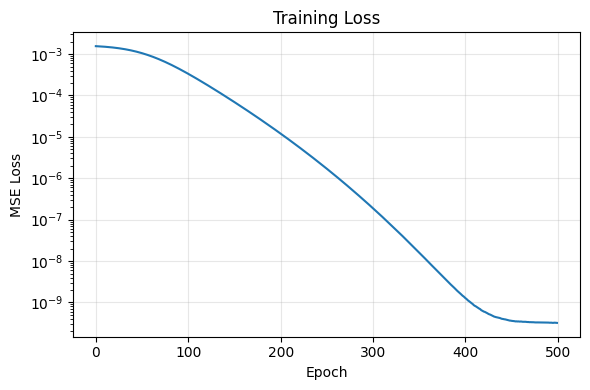

In [24]:
# --- Loss curve ---
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogy(loss_history)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

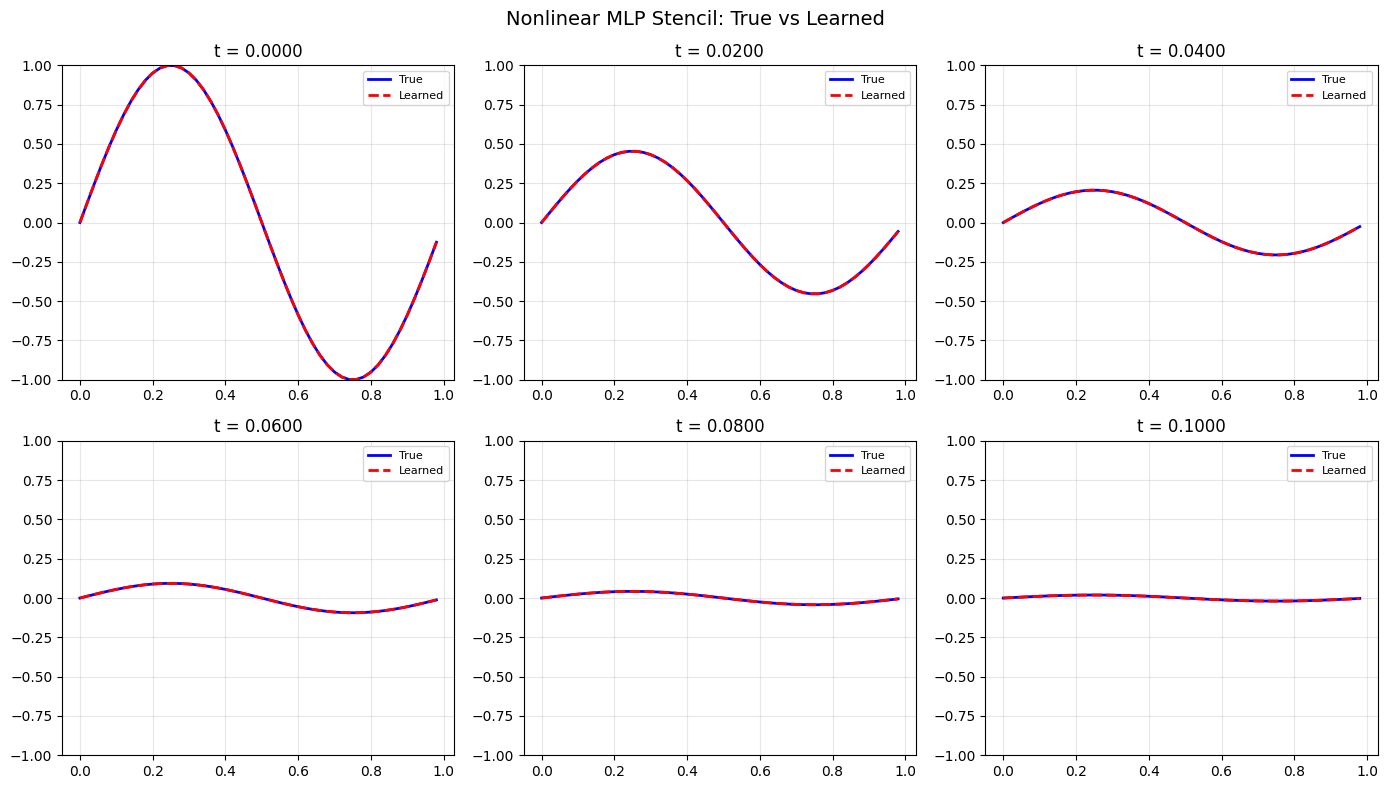

In [25]:
# --- Roll out learned model and compare to truth ---
mlp.eval()
mlp_params_eval = dict(mlp.named_parameters())
mlp_buffers_eval = dict(mlp.named_buffers())

M_test = 10  # roll out further than training
t_test = torch.linspace(0, dt * M_test, M_test + 1, device=device)
u_true_test = torch.stack([
    torch.exp(-4 * torch.pi**2 * t) * torch.sin(2 * torch.pi * x_grid)
    for t in t_test
])

u_learned = torch.zeros(M_test + 1, N, device=device)
u_learned[0] = u_true_test[0].clone()

with torch.no_grad():
    for step in range(M_test):
        u_learned[step + 1] = newton_solve(
            u_learned[step], u_learned[step], dt,
            mlp_params_eval, mlp_buffers_eval, mlp_forward,
            base_coeffs, tol=1e-10, max_iter=20
        )

# Plot snapshots
x_np = x_grid.numpy()
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Nonlinear MLP Stencil: True vs Learned', fontsize=14)
snap_idx = [0, 2, 4, 6, 8, M_test]
for idx, si in enumerate(snap_idx):
    ax = axes[idx // 3, idx % 3]
    ax.plot(x_np, u_true_test[si].numpy(), 'b-', lw=2, label='True')
    ax.plot(x_np, u_learned[si].numpy(), 'r--', lw=2, label='Learned')
    ax.set_title(f't = {t_test[si]:.4f}')
    ax.set_ylim([-1, 1])
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

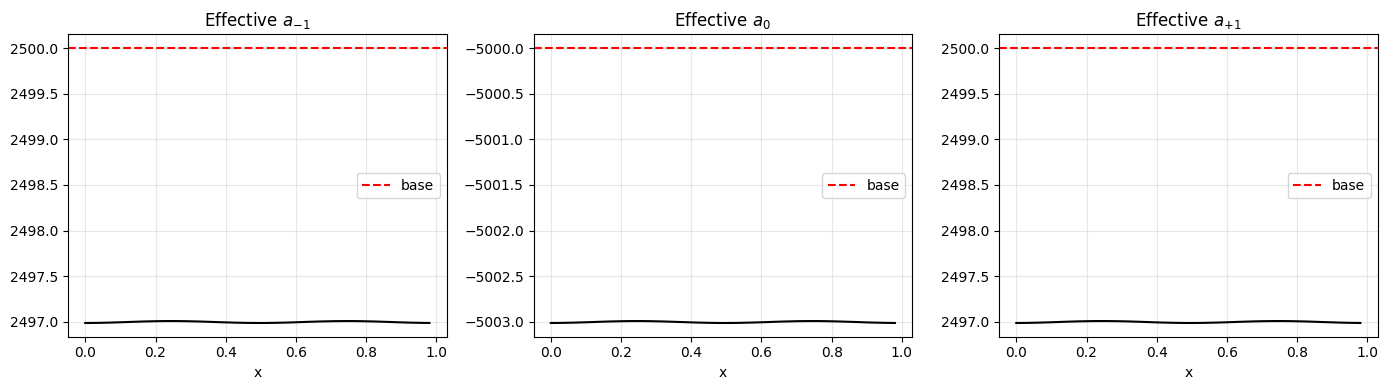

In [28]:
with torch.no_grad():
    windows_ic = extract_stencil_windows(u_true_test[0])
    delta_a_ic = mlp_forward(mlp_params_eval, mlp_buffers_eval, windows_ic)
    a_eff_ic = base_coeffs.unsqueeze(0) + delta_a_ic

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
labels = ['$a_{-1}$', '$a_0$', '$a_{+1}$']
for k in range(3):
    axes[k].plot(x_np, a_eff_ic[:, k].numpy(), 'k-', lw=1.5)
    axes[k].axhline(base_coeffs[k].item(), color='r', ls='--', label='base')
    axes[k].set_title(f'Effective {labels[k]}')
    axes[k].set_xlabel('x')
    axes[k].legend()
    axes[k].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()